# Atividade 02

Aluno: Luiz Guilherme Seleme Fofano<br>
Disciplina: HIML<br>

## 1 - Importação

In [1]:
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt

In [2]:
fname = join(getcwd(),'data','data3SS2009.mat')
mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)

y

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5

In [3]:
Nc

850

(8192, 850)


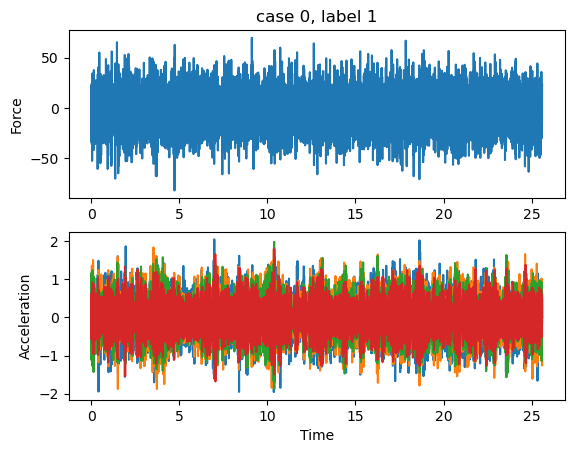

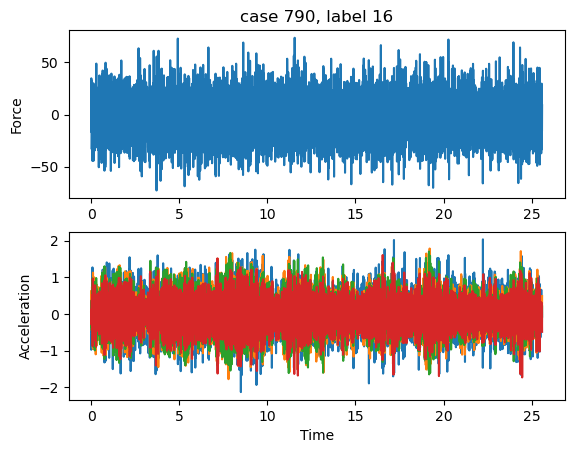

In [4]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
print(Ch1.shape)
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

## 2 - AR

In [5]:
from statsmodels.tsa.ar_model import AutoReg

In [6]:
channels = [Ch2, Ch3, Ch4, Ch5]
AR = []
order = 29 # para ficar com 30 colunas por canal (n+1)

for channel in channels:
    exp = []
    for case in range(Nc):
        reg = AutoReg(channel[:,case],lags=order).fit()
        exp.append(reg.params)
    exp = np.vstack(exp)
    AR.append(exp)

X1 = np.hstack(AR)       

In [7]:
X1.shape

(850, 120)

## 3 - PCA

In [8]:
from sklearn.decomposition import PCA

[0.64699238 0.12653811 0.09021831 0.0510888  0.02622314 0.01953216]


São necessários 6 componentes para atingir uma variância explicada de 0.9605929074910382 (>95%)


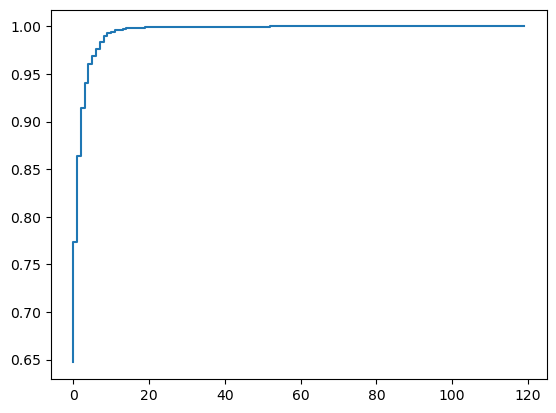

In [22]:
pca = PCA().fit(X1)

exp_var = pca.explained_variance_ratio_
cum_var = np.cumsum(exp_var)

plt.step(range(0,len(cum_var)),cum_var,label='Cumulative variance')

nc_pca = 0.95
pca = PCA(n_components=nc_pca).fit(X1)
exp_var = pca.explained_variance_ratio_
cum_var = np.cumsum(exp_var)
print(exp_var)

print(f'\n\nSão necessários {len(exp_var)} componentes para atingir uma variância explicada de {cum_var[-1]} (>95%)')


X2 = pca.transform(X1)

In [10]:
import pandas as pd

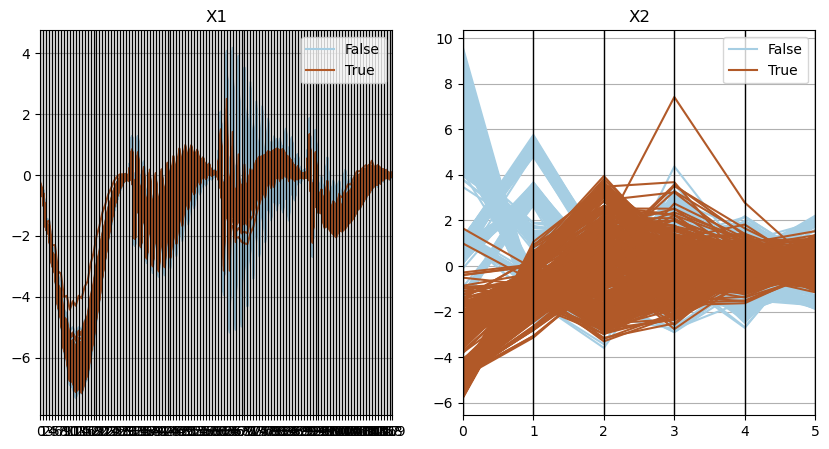

In [11]:
#Visualizando X1 e X2

indDam = y > 9
X1y = pd.concat([pd.DataFrame(X1),pd.DataFrame({'target':indDam})],axis=1)
X2y = pd.concat([pd.DataFrame(X2),pd.DataFrame({'target':indDam})],axis=1)

plt.figure(figsize=[10,5])
ax1 = plt.subplot(121)
pd.plotting.parallel_coordinates(X1y,'target',colormap=plt.get_cmap('Paired'))
ax1.title.set_text('X1')
ax2 = plt.subplot(122)
pd.plotting.parallel_coordinates(X2y,'target',colormap=plt.get_cmap('Paired'))
ax2.title.set_text('X2')

Pode-se perceber que no caso com X1 a diferenciação entre os casos com e sem dano passa a ser mais visível nos parâmetros relativos ao Ch4 (60 < n < 90), o que faz sentido dado que esse é o canal do andar do bumper no experimento.

Quanto ao X2, como a maior parcela da variância é explicada pelo componente 1, a tendência das curvas muda e a separação é maior nos primeiros componentes

## 4 - Ajuste de Escala

Utilizando o MinMaxScaler e ajustando para ficar no intervalo [-1,1]

In [12]:
from sklearn.preprocessing import MinMaxScaler

[0.38346489 0.21679077 0.10295849 0.07803741 0.05185288 0.03813155
 0.03729472 0.02522116 0.01423156 0.0120935 ]

São necessários 10 componentes para atingir uma variância explicada de 0.9600769273913062 (>95%) no caso em que o conjunto considerado para PCA é o X1_sc


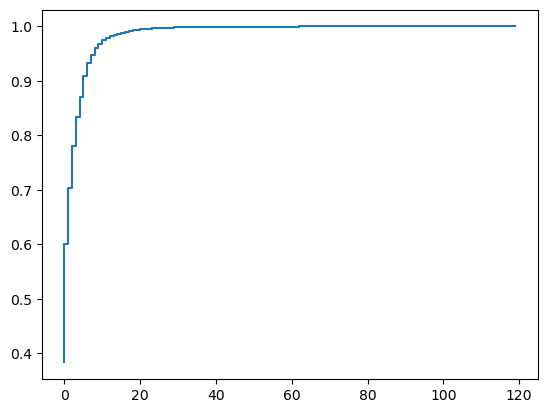

In [13]:
scaler = MinMaxScaler(feature_range=(-1,1))

X1_sc = scaler.fit(X1).transform(X1)

X2_sc2 = scaler.fit(X2).transform(X2)

pca_sc = PCA().fit(X1_sc)

exp_var_sc = pca_sc.explained_variance_ratio_
cum_var_sc = np.cumsum(exp_var_sc)

plt.step(range(0,len(cum_var_sc)),cum_var_sc,label='Cumulative variance')

nc_pca_sc = 0.95
pca_sc = PCA(n_components=nc_pca_sc).fit(X1_sc)
exp_var_sc = pca_sc.explained_variance_ratio_
cum_var_sc = np.cumsum(exp_var_sc)

print(exp_var_sc)

print(f'\nSão necessários {len(exp_var_sc)} componentes para atingir uma variância explicada de {cum_var_sc[-1]} (>95%) no caso em que o conjunto considerado para PCA é o X1_sc')

X2_sc = pca_sc.transform(X1_sc)

Pode-se perceber que o número de componentes necessário para representar 95% da variância do conjunto com ajuste de escala é de 10, maior que no caso original.

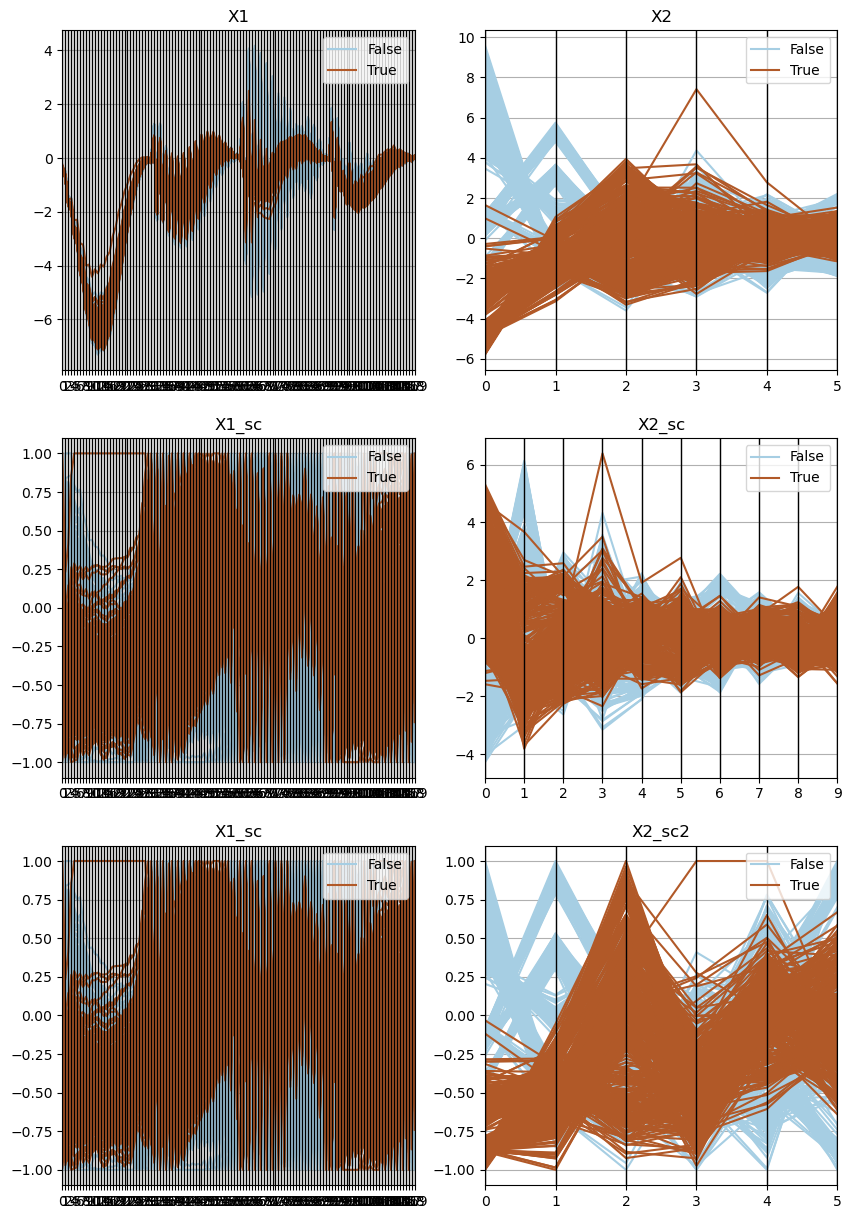

In [14]:
#Visualizando X1sc, X2sc e X2sc2 comparado a X1 e X2

indDam = y > 9
X1ysc = pd.concat([pd.DataFrame(X1_sc),pd.DataFrame({'target':indDam})],axis=1)
X2ysc = pd.concat([pd.DataFrame(X2_sc),pd.DataFrame({'target':indDam})],axis=1)

X2ysc2 = pd.concat([pd.DataFrame(X2_sc2),pd.DataFrame({'target':indDam})],axis=1)

plt.figure(figsize=[10,15])
ax1 = plt.subplot(321)
pd.plotting.parallel_coordinates(X1y,'target',colormap=plt.get_cmap('Paired'))
ax1.title.set_text('X1')

ax2 = plt.subplot(322)
pd.plotting.parallel_coordinates(X2y,'target',colormap=plt.get_cmap('Paired'))
ax2.title.set_text('X2')

ax3 = plt.subplot(323)
pd.plotting.parallel_coordinates(X1ysc,'target',colormap=plt.get_cmap('Paired'))
ax3.title.set_text('X1_sc')

ax4 = plt.subplot(324)
pd.plotting.parallel_coordinates(X2ysc,'target',colormap=plt.get_cmap('Paired'))
ax4.title.set_text('X2_sc')

ax5 = plt.subplot(325)
pd.plotting.parallel_coordinates(X1ysc,'target',colormap=plt.get_cmap('Paired'))
ax5.title.set_text('X1_sc')

ax6 = plt.subplot(326)
pd.plotting.parallel_coordinates(X2ysc2,'target',colormap=plt.get_cmap('Paired'))
ax6.title.set_text('X2_sc2')

Comparando os casos normalizados (X1_sc e X2_sc), fica mais difícil ver uma tendência de diferenciação entre os canais, por questão da escala no gráfico, mas podemos perceber que no PCA continua a tendência de redução da diferenciação nos últimos componentes.

Quando fazemos o ajuste de escala direto em X2 (X2_sc2), sem novo PCA após normalização de X1, o contraste volta a ser mais claro, como no caso original X2.

## 5 - Softmax

Serão considerados os conjuntos obtidos anteriormente:

* X1 : dados AR
* X2 : X1 pós-PCA (95% variância explicada)
* X1_sc : ajuste de escala em X1
* X2_sc : X1_sc pós-PCA (95% variância explicada)
* X2_sc2 : ajuste de escala diretamente em X2

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
#Usando X1
logreg = LogisticRegression(multi_class='multinomial',max_iter=10000).fit(X1, y)

score = logreg.score(X1, y)

print(f'Score de X1: {score}')

Score de X1: 0.9964705882352941


In [17]:
# Usando X2
logreg = LogisticRegression(multi_class='multinomial',max_iter=10000).fit(X2, y)

score = logreg.score(X2, y)

print(f'Score de X2: {score}')

Score de X2: 0.9376470588235294


In [18]:
# Usando X1_sc
logreg = LogisticRegression(multi_class='multinomial',max_iter=10000).fit(X1_sc, y)

score = logreg.score(X1_sc, y)

print(f'Score de X1_sc: {score}')

Score de X1_sc: 0.9988235294117647


In [19]:
# Usando X2_sc
logreg = LogisticRegression(multi_class='multinomial',max_iter=10000).fit(X2_sc, y)

score = logreg.score(X2_sc, y)

print(f'Score de X2_sc: {score}')

Score de X2_sc: 0.9952941176470588


In [20]:
# Usando X2_sc2
logreg = LogisticRegression(multi_class='multinomial',max_iter=10000).fit(X2_sc2, y)

score = logreg.score(X2_sc2, y)

print(f'Score de X2_sc2: {score}')

Score de X2_sc2: 0.908235294117647


## 6 - Conclusão

A regressão usando o conjunto X1, normalizado ou original, retornou um score acima de 0.99.
Utilizando os conjuntos pós-PCA na regressão, o conjunto original obteve um score abaixo dos demais (0.93), enquanto que a regressão com o PCA após normalização de X1 voltou a obter um score acima de 0.99. O pior score foi obtido na regressão do conjunto PCA original após normalização (0.9)

O PCA reduziu o número de dimensões de 120 para 6 no caso sem ajuste de escala e de 120 para 10 após ajuste, considerando uma variância explicada de 95%.




